# Predicting mRNA Degradation for Vaccine Development
The [Das Lab at Stanford](https://daslab.stanford.edu/) has provided experimental results to better understand how the RNA sequence determines its degradation rates. RNA vaccines are relatively unstable and require storage at -80C temperatures. 

![image.png](image.png)



## Dataset
* 2400 RNA molecules in a training set. Length 107 base pairs.
* 629 RNA molecules in a public test set. Length 107 base pairs
* 3005 RNA molecules in a private test set. Length 140 base pairs.

    ### Inputs   
* `sequence`: RNA sequence 'AUGCAGUAUC...'
* `structure`: sequence like '(((...)))...((..(..)).)' where '(' and ')' are paired bases and '.' is unpaired.
* `predicted_loop_type`: sequence like 'EEESSISSSBBSHHHSSSXX...' for the estimated structural context (Loop, Hairpin Loop, Stem, etc.)
* `bpps`: Base Pairing Probability Matrix. Probability that position $i$ pairs with position $j$.   
    
    ### Predicted Outputs
* `reactivity`: array of floats for measure reactivity at each position
* `deg_Mg_ph10`: similar to `reactivity` when in a magnesium solution at pH 10.
* `deg_Mg_50C`: similar to `reactivity` when in a magnesium solution at 50C.
* Only the first 68 positions used for public set and first 91 positions used for private set
    

## Approach
* **Extract features** from the Base Pairing Matrix
* **Filter and weight** samples by signal-to-noise ratio.
* **Augment the data** by generating secondary structural annotations for each RNA sequence and adding reversed sequences. 
* **Group similar sequences** in cross-validation folds
* Use **denoising autoencoder** for pre-training
* Use Base Pairing Matrix to aggregate neighborhoods and combine with Bidirectional LSTM layers.

## Imports and Loading Data

In [1]:
# Imports
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import OneHotEncoder
import nltk

In [2]:
RUN_TEST = False
AUGMENT = True
FOLDS = 4
SNR_THRESHOLD = 0.3
WEIGHTING = 'log'

In [3]:
# Set seed for reproducibility
SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [4]:
def load_data():
    data_dir = '/kaggle/input/stanford-covid-vaccine/'
    train_df = pd.read_json(data_dir + 'train.json', lines = True)
    test_df = pd.read_json(data_dir + 'test.json', lines = True)
    sample_submission = pd.read_csv(data_dir + 'sample_submission.csv')
    return train_df, test_df, sample_submission
train_df, test_df, sample_submission =  load_data()

In [5]:
if RUN_TEST:
    train_df = train_df.iloc[:30]
    test_df = test_df.iloc[:30]

In [6]:
train_df.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


## Features from Base Pairing Probabilities
The base pairing probability matrix $B(i,j)$ shows that bases at $i$ can pair with bases at multiple other positions, $j$, with varying probabilities. 

### Features
* `bpps_max`: max probability = max of $B(i,j)$ over $j$.
* `bpps_sum`: total probability = sum of $B(i,j)$ over $j$.
* `bpps_ent`: entropy of probability distribution = $\sum_j -B(i,j) \log_2 B(i,j)$
    * This roughly measures how much the distribution is spread out over different positions in a length-independent way.
   
### Length-dependent features (not used)
* mean probability: the additional entries for longer sequences are mostly 0 (i.e. no pairing) so the mean becomes smaller.
* number of nonzero $B(i,j)$: sensitive to even small non-zero probabilities that may appear more often for longer sequences.

<Figure size 720x720 with 0 Axes>

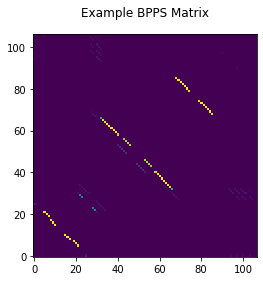

In [7]:
bpps_dir = '../input/stanford-covid-vaccine/bpps/'
files = os.listdir(bpps_dir)
bpps = np.load(bpps_dir + files[15])

plt.figure(figsize=(10,10))
plt.matshow(bpps, vmax=1, origin='lower') 
plt.title('Example BPPS Matrix');
plt.gca().xaxis.tick_bottom();

In [8]:
def get_adj_and_bpps_features(df):
    # Add features to dataframe
    bpps_dir = '../input/stanford-covid-vaccine/bpps/'
    ids = df.id
    bpps_max = []
    bpps_sum = []
    bpps_ent = []
    adj_matrices = []
    for id in ids:
        bpps = np.load(bpps_dir+f'{id}.npy')
        adj_matrices.append(bpps)
        bpps_max.append(list(np.max(bpps,axis=1)))
        bpps_sum.append(list(np.sum(bpps,axis=1)))
        ent = np.zeros(bpps.shape)
        ent[bpps>0] = -bpps[bpps>0]*np.log2(bpps[bpps>0])
        ent_bool = np.any(np.isnan(ent),axis=1)
        if np.any(ent_bool):
            break
        bpps_ent.append(list(np.sum(ent,axis=1)))
    bpps_df = pd.DataFrame({'id':ids, 'bpps_max':bpps_max, 'bpps_sum':bpps_sum, 
                            'bpps_ent':bpps_ent, 'adj':adj_matrices})
    df = df.join(bpps_df.set_index('id'),on='id',how='left')
    return df

In [9]:
train_df = get_adj_and_bpps_features(train_df)
test_df= get_adj_and_bpps_features(test_df)

In [10]:
train_df.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,...,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,bpps_max,bpps_sum,bpps_ent,adj
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...",...,"[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000...","[0.0217857, 0.0386527, 0.0275904, 0.00947066, ...","[0.19854229, 0.18371220000000002, 0.0600024000...","[1.346286163466997, 1.1568771856530944, 0.3521...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0065541..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...",...,"[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.11931483477784201, 0.0808186531761711, 0.06...","[0.16883627604054915, 0.10675940059456464, 0.0...","[0.7139953708480266, 0.49688443977941066, 0.27...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...",...,"[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499...","[0.017340043515196805, 0.00826566577930985, 0....","[0.06680724164624499, 0.04433748694733778, 0.0...","[0.4557274867196661, 0.36183033754399374, 0.16...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000229676025..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...",...,"[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.0350158, 0.0332295, 0.00272567, 0.0, 0.0, 0...","[0.22702912000000003, 0.18439387000000002, 0.0...","[1.2112663032584108, 1.106599480137432, 0.0354...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...",...,"[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,...","[0.02230060114516417, 0.052274223411953764, 0....","[0.04036075455181073, 0.08021642791992274, 0.0...","[0.27041803173894285, 0.40371453754430126, 0.3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.459919782212.

# Signal-to-noise Ratio

* Some sequences have much lower signal-to-noise ratios (SNRs).
* Filter out sequences below `SNR_THRESHOLD`
* Need to weight sequences by SNR or measurement error. 
    * 'log': weight = log(SNR + 1)/2. Gives a reasonable range of weight values based on SNR. 
    * 'inv_err':  weight = 1/error. Normalizes each prediction error, $\hat{y}-y$, by the measurement error on a per position basis. 

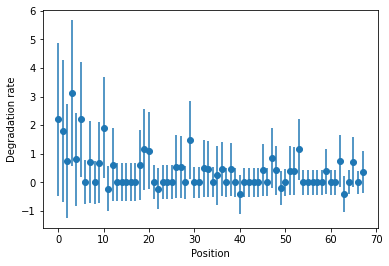

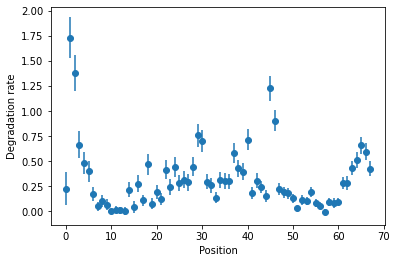

In [11]:
def plot_err(index):
    deg = train_df.loc[index,'deg_Mg_50C']
    err = train_df.loc[index,'deg_error_Mg_50C']
    plt.errorbar(np.arange(len(deg)),deg,err,fmt='o')
    plt.ylabel('Degradation rate')
    plt.xlabel('Position')
    
plt.figure()
plot_err(4)
plt.figure()
plot_err(5)

In [12]:
def get_weights(df, WEIGHTING):
    if WEIGHTING=='log':
        snr = df['signal_to_noise'].values
        weights = np.log(snr+1.1)/2
    elif WEIGHTING=='inv_err':
        err_cols = ['reactivity_error','deg_error_Mg_pH10','deg_error_Mg_50C']
        err_df = df[err_cols]
        errs = np.array(err_df.apply(lambda x: np.mean([x[col] for col in err_cols],axis=0),axis=1).values.tolist())
        weights = 1/errs
        weights = weights/np.median(weights)  #sets typical weight to one
    else:
        weights = np.ones((df.shape[0]))
    return weights

Text(0, 0.5, 'Prob. Density')

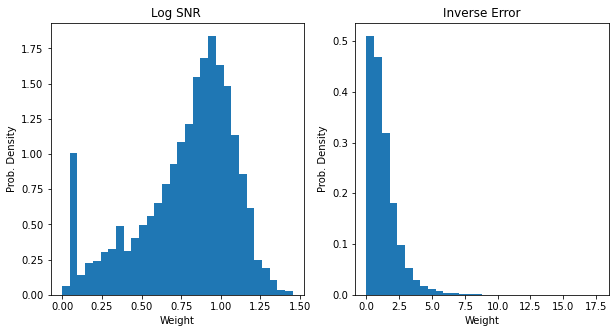

In [13]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
weights_log = get_weights(train_df,'log')
plt.hist(weights_log,30,density=True);
plt.title('Log SNR ')
plt.xlabel('Weight')
plt.ylabel('Prob. Density')

plt.subplot(1,2,2)
weights_inv = get_weights(train_df,'inv_err')
plt.hist(weights_inv.flatten(),30,density=True);
plt.title('Inverse Error')
plt.xlabel('Weight')
plt.ylabel('Prob. Density')

# Augmentation
* Generate one additional set of `structure` and `predicted_loop_type` sequences for every RNA molecule `sequence` using biochemical models in the [ViennaRNA](https://www.tbi.univie.ac.at/RNA/) package. 
* Add reversed sequences to the dataset. Easier to online at the model building step.

In [14]:
def add_secondary_structures(df, aug_df):
    already_added = 'log_gamma' in df.columns
    if not already_added:
        target_df = df.copy()
        new_df = aug_df[aug_df['id'].isin(target_df['id'])]

        del target_df['structure']
        del target_df['predicted_loop_type']
        new_df = new_df.merge(target_df, on=['id','sequence'], how='left')

        df['cnt'] = df['id'].map(new_df[['id','cnt']].set_index('id').to_dict()['cnt'])
        df['log_gamma'] = 100
        df['score'] = 1.0
        df = df.append(new_df[df.columns],ignore_index=True)
    return df

In [15]:
if AUGMENT:
    aug_df = pd.read_csv('../input/open-vacine-second-structure-data/aug_data.csv')
    train_df = add_secondary_structures(train_df,aug_df)
    test_df = add_secondary_structures(test_df,aug_df)


# 3-Hot Encoding

Concatenate one-hot encodings for `sequence`, `structure`, and `predicted_loop_type` categorical features. 

In [16]:
# columns we are predicting
cat_input_cols = ['sequence', 'structure', 'predicted_loop_type']
num_input_cols = ['bpps_max', 'bpps_sum', 'bpps_ent']

def encoding(df):
    encoder = get_encoder()
    cat_inputs = df[cat_input_cols].apply(lambda x: three_hot_encoding_single_row(x,encoder),axis=1)
    cat_inputs = df_to_array(cat_inputs)
    num_inputs = np.transpose(df_to_array(df[num_input_cols]),(0,2,1))
    inputs = np.concatenate((cat_inputs,num_inputs),axis=-1)
    return inputs

def three_hot_encoding_single_row(row,encoder):
    tokens = list(zip(*[row[col] for col in cat_input_cols]))
    inputs_encoded = encoder.fit_transform(tokens).toarray()
    return inputs_encoded

def get_encoder():
    bases = 'AUGC'
    structs = '().'
    loops = 'BEHIMSX'
    encoder = OneHotEncoder(categories=[list(bases),list(structs),list(loops)])
    return encoder

def df_to_array(df):
    return np.array(df.to_numpy().tolist())

# Group Similar Sequences

* Find that some sequences are more similar to each other. 
* Similar sequences can lead to **leakage** between training and validation sets. This can lead to overfitting.
* **Cluster** sequences into many clusters.
* Use `GroupKFold` from `sklearn` to create cross validation folds with clusters kept together. 


In [17]:
distances = []
ii = 2
for jj in range(ii,len(train_df)):
    distance = nltk.edit_distance(train_df.loc[ii,'sequence'],train_df.loc[jj,'sequence'])
    distances.append(distance)

Text(0.5, 1.0, 'Distances to a single sequence')

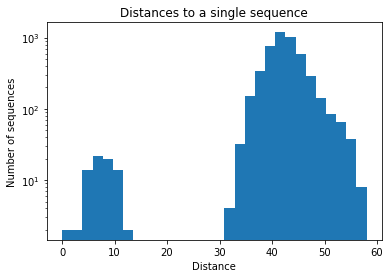

In [18]:
plt.hist(distances,30)
plt.yscale('log')
plt.xlabel('Distance')
plt.ylabel('Number of sequences')
plt.title('Distances to a single sequence')

In [19]:
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C', 'deg_pH10', 'deg_50C']

class Preprocessor():
    def __init__(self,train_df):
        self.train_df = train_df
        
    def get_cv_folds(self):
        inputs, preds, weights = self.get_inputs_predictions_weights()
        self.pass_index, self.fail_index = self.define_filter_indexes()
        labels = self.get_cluster_labels()
        
        gkf = GroupKFold(FOLDS)
        cv_folds = []
    
        stratify = self.train_df['signal_to_noise']  #stratify folds 
        for train_idx, val_idx in gkf.split(inputs[0][self.pass_index], stratify[self.pass_index], labels[self.pass_index]):
            x_train = [self.concat_pass_fail(single_input,train_idx) for single_input in inputs]
            y_train = self.concat_pass_fail(preds,train_idx)
            x_val = [single_input[self.pass_index][val_idx] for single_input in inputs]
            y_val = preds[self.pass_index][val_idx]
            w_train = self.concat_pass_fail(weights,train_idx)
            cv_folds.append((x_train,y_train,x_val,y_val,w_train))
        return cv_folds
        
    def get_inputs_predictions_weights(self):
        inputs = self.get_inputs()
        preds = np.transpose(df_to_array(self.train_df[pred_cols]),(0,2,1))
        weights = get_weights(self.train_df,WEIGHTING)
        return inputs, preds, weights
    
    def get_inputs(self):
        inputs_encoded = encoding(self.train_df)
        adj = df_to_array(self.train_df['adj'])
        return [inputs_encoded, adj]
    
    def define_filter_indexes(self):
        pass_index = self.train_df['SN_filter']==1
        fail_index = np.logical_and(np.logical_not(pass_index), self.train_df['signal_to_noise']>SNR_THRESHOLD)
        return pass_index, fail_index
    
    def get_cluster_labels(self,n_clusters = 200):
        base2int = {'A':0, 'U':1, 'G':2, 'C':3}
        seq = self.train_df['sequence'].apply(lambda seq: [base2int[x] for x in seq])
        seq = np.array(seq.to_list())
        if not RUN_TEST:
            kmeans_model = KMeans(n_clusters=n_clusters, random_state=SEED).fit(seq)
            labels = kmeans_model.labels_
        else:
            labels = np.random.choice(10,size=len(self.train_df))
        return labels
    
    def concat_pass_fail(self,array,train_idx):
        return np.concatenate((array[self.pass_index][train_idx],array[self.fail_index]))



In [20]:
cv_folds = Preprocessor(train_df).get_cv_folds()

In [21]:
(x_train,y_train,x_val,y_val,w_train) = cv_folds[0]
print([x_train[0].shape, y_train.shape, x_val[0].shape, y_val.shape,w_train.shape])

[(3710, 107, 17), (3710, 68, 5), (796, 107, 17), (796, 68, 5), (3710,)]


# Loss Function
Loss is evaluated as the mean column-wise root-mean-square error (MCRMSE), where the RMS is taken over all positions (p) in all molecules (m), $$RMS  = \sqrt{\frac{1}{M P}\sum^M_m \sum^P_p (\hat{y}_{mp} - y_{mp})^2}$$

In [22]:
#Define Loss Function
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(0, 1))
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1)

# Model

## Aggregation based on base pairing
Used a layer involving matrix multiplication over the Base Pairing Probabilities matrix to combine representations for distantly paired bases. 

## Denoising Autoencoder 
* Trained an autoencoder to predict original RNA sequence from input sequence with 30% of positions masked. 
* Base model architecture: 4x (BiLSTM --> Aggregation --> Forward layer with residual connection)

## Predictive model
* Base model + 3x (BiLSTM) + Dense layer

## Attention mechanism
Explored using a multi-headed attention mechanism in the autoencoder but did not perform as well as the BiLSTM layers. 

In [23]:
def aggregrate_adjacent(x, adj, units, distance = 3, dropout = 0.1):
    #Use adjacency matrix (base pairing probabilities) to combine representations 
    # from connected base pairs.
    x_agg = x
    x_aggs = [x]
    for i in range(distance):
        x_agg = tf.matmul(adj, x_agg) #aggregate adjacent based on base pairing probabilities.
        x_aggs.append(x_agg)
    x = layers.Concatenate()(x_aggs)
    x = layers.Conv1D(units,1)(x)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(dropout)(x)
    return x

def lstm_layer(x,units, dropout):
    x = layers.Bidirectional(
              layers.LSTM(units,dropout=dropout, return_sequences=True,
                     kernel_initializer = 'orthogonal'))(x)
    return x

def forward(x,units,dropout=0.1):
    y1 = layers.Dense(2*units,activation='relu')(x)
    y2 = layers.Dense(units,activation='relu')(x)
    z = layers.Dense(units, activation = 'relu')(y1)
    x = layers.Add()([z,y2])
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout)(x)
    return x

def attention(x_inner, x_outer, key_dim):
    # The convolutions act as linear transformations.
    x_Q =  layers.Conv1D(key_dim, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_inner)
    x_K =  layers.Conv1D(key_dim, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_outer)
    x_V =  layers.Conv1D(key_dim, 1, activation='linear', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(x_outer)
    x_KT = layers.Permute((2, 1))(x_K)
    res = layers.Lambda(lambda c: keras.backend.batch_dot(c[0], c[1]) / np.sqrt(key_dim))([x_Q, x_KT])
    att = layers.Lambda(lambda c: keras.backend.softmax(c, axis=-1))(res)
    att = layers.Lambda(lambda c: keras.backend.batch_dot(c[0], c[1]))([att, x_V])
    return att

def multi_head_attention(x, y, units, n_heads, dropout=0.1):
    key_dim = units//n_heads
    heads = [attention(x, y, key_dim) for i in range(n_heads)]
    att = layers.Concatenate()(heads)
    att = layers.Dense(x.shape[-1], 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='glorot_uniform',
                 )(att)
    x = layers.Add()([x, att])
    x = layers.LayerNormalization()(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    return x



def get_base_model(seq_len = 107, pred_len = 68):
    ## base model architecture 

    encode_dim = 14
    num_features = 3
    inputs = layers.Input(shape=(seq_len, encode_dim + num_features))
    adj = layers.Input(shape=(seq_len,seq_len))
        
    x = inputs
    x_list = []
    for units in [128,64, 64, 32]:
#         x = multi_head_attention(x, x, 2*units, n_heads=8)
        x = lstm_layer(x,units,dropout=0.1)
        x = aggregrate_adjacent(x, adj, units)
        x = forward(x,units)
        x_list.append(x)
    x = layers.Concatenate()(x_list)
    model = keras.Model(inputs = [inputs, adj], outputs = x)
    return model


def get_autoencoder(base_model,seq_len=107,pred_len=68):
    ## denoising auto encoder part
    
    encode_dim = 14
    num_features = 3
    inputs = layers.Input(shape=(seq_len, encode_dim + num_features))
    adj = layers.Input(shape=(seq_len,seq_len))
    
    x = base_model([layers.SpatialDropout1D(0.3)(inputs), adj])
    x = forward(x, 64)
    probs = layers.Dense(encode_dim, "sigmoid")(x)
    
    input_encoding = inputs[:,:,:encode_dim]
    
    loss = - tf.reduce_mean(20 * input_encoding * tf.math.log(probs + 1e-4) 
                            + (1 - input_encoding) * tf.math.log(1 - probs + 1e-4))
    model = keras.Model(inputs = [inputs, adj], outputs = loss)
    
    opt = get_optimizer()
    model.compile(optimizer = opt, loss = lambda t, y : y)
    return model

def get_model(base_model,seq_len=107,pred_len=68):
    ## regression part
    ## node, adj -> middle feature -> prediction of targets
    
    encode_dim = 14
    num_features = 3
    inputs = layers.Input(shape=(seq_len, encode_dim + num_features))
    adj = layers.Input(shape=(seq_len,seq_len))
    
    x = base_model([inputs, adj])
    x = lstm_layer(x,128, dropout = 0.1)
    x = lstm_layer(x,64, dropout = 0.1)
    x = lstm_layer(x,32, dropout = 0.1)
    x = layers.Dense(5,activation='linear')(x)
    x = x[:,:pred_len]

    model = keras.Model(inputs = [inputs, adj], outputs = x)
    
    opt = get_optimizer()
    model.compile(optimizer = opt, loss = MCRMSE)
    return model

def get_optimizer(learning_rate = 0.003):
    return tf.optimizers.Adam(learning_rate = learning_rate)

In [24]:
base_model = get_base_model()
autoencoder = get_autoencoder(base_model)
model = get_model(base_model)
autoencoder.summary()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 107, 17)]    0                                            
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 107, 17)      0           input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 107, 107)]   0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 107, 288)     674592      spatial_dropout1d[0][0]          
                                                                 input_4[0][0]         

In [25]:
histories = []
for ii in range(len(cv_folds)):
    x_train,y_train,x_val,y_val,w_train=cv_folds[ii]
    base_model = get_base_model()
    autoencoder = get_autoencoder(base_model)
    model = get_model(base_model)
    auto_history = autoencoder.fit(x_train, y_train,
            batch_size=64, 
            epochs=20, 
            verbose=2, 
            sample_weight=w_train)

    history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
            batch_size=64, 
            epochs=50, 
            verbose=2, 
            sample_weight=w_train,
            callbacks=[
#                         keras.callbacks.ReduceLROnPlateau(patience = 10, factor=0.3),
#                        keras.callbacks.ModelCheckpoint(f'model_{ii}.h5',save_weights_only = True,save_best_only=True)
                       keras.callbacks.EarlyStopping(patience=10,restore_best_weights = True)
                      ])
    histories.append(history)
    model.save_weights(f'model_{ii}.h5')

Epoch 1/20
58/58 - 4s - loss: 0.8554
Epoch 2/20
58/58 - 4s - loss: 0.2594
Epoch 3/20
58/58 - 4s - loss: 0.1554
Epoch 4/20
58/58 - 4s - loss: 0.1109
Epoch 5/20
58/58 - 4s - loss: 0.1094
Epoch 6/20
58/58 - 4s - loss: 0.0916
Epoch 7/20
58/58 - 4s - loss: 0.0821
Epoch 8/20
58/58 - 4s - loss: 0.0787
Epoch 9/20
58/58 - 4s - loss: 0.0805
Epoch 10/20
58/58 - 4s - loss: 0.0728
Epoch 11/20
58/58 - 4s - loss: 0.0670
Epoch 12/20
58/58 - 4s - loss: 0.0661
Epoch 13/20
58/58 - 4s - loss: 0.0655
Epoch 14/20
58/58 - 4s - loss: 0.0582
Epoch 15/20
58/58 - 4s - loss: 0.0591
Epoch 16/20
58/58 - 4s - loss: 0.0581
Epoch 17/20
58/58 - 4s - loss: 0.0581
Epoch 18/20
58/58 - 4s - loss: 0.0554
Epoch 19/20
58/58 - 4s - loss: 0.0519
Epoch 20/20
58/58 - 4s - loss: 0.0684
Epoch 1/50
58/58 - 14s - loss: 0.3877 - val_loss: 0.3542
Epoch 2/50
58/58 - 6s - loss: 0.3122 - val_loss: 0.3032
Epoch 3/50
58/58 - 6s - loss: 0.2923 - val_loss: 0.2915
Epoch 4/50
58/58 - 6s - loss: 0.2814 - val_loss: 0.2828
Epoch 5/50
58/58 - 6s - 

Text(0.5, 1.0, 'Training History')

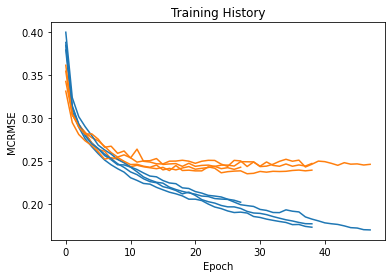

In [26]:
for ii, history in enumerate(histories):
    loss =  history.history['loss']
    val_loss = history.history['val_loss']
    if ii==0:
        plt.plot(loss, color='C0', label='Loss')
        plt.plot(val_loss, color='C1', label='Val. Loss')
    else:
        plt.plot(loss, color='C0')
        plt.plot(val_loss, color='C1')
plt.xlabel('Epoch')
plt.ylabel('MCRMSE')
plt.title('Training History')

# Predictions

In [27]:
public_df = test_df.query("seq_length == 107")
private_df = test_df.query("seq_length == 130")

public_inputs = encoding(public_df)
private_inputs = encoding(private_df)
public_adj = df_to_array(public_df['adj'])
private_adj = df_to_array(private_df['adj'])

In [28]:
n_models = len(histories)
for ii in range(n_models):
    
    base_model = get_base_model(seq_len=107, pred_len=107)
    model_public = get_model(base_model,seq_len=107, pred_len=107)
    
    base_model = get_base_model(seq_len=130, pred_len=130)
    model_private = get_model(base_model,seq_len=130, pred_len=130)

    model_public.load_weights(f'model_{ii}.h5')
    model_private.load_weights(f'model_{ii}.h5')
    
    if ii == 0:
        public_preds = model_public.predict([public_inputs,public_adj])/n_models
        private_preds = model_private.predict([private_inputs,private_adj])/n_models
    else:
        public_preds += model_public.predict([public_inputs,public_adj])/n_models
        private_preds += model_private.predict([private_inputs,private_adj])/n_models
    

In [29]:
preds_ls = []

for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
    for i, uid in enumerate(df.id.unique()):
        single_pred = np.mean(preds[df['id']==uid],axis=0)
        single_df = pd.DataFrame(single_pred, columns=pred_cols)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]
        
        target_cols = ['id_seqpos', 'reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
        preds_ls.append(single_df[target_cols])

preds_df = pd.concat(preds_ls)
preds_df.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.764608,0.799626,1.921146,0.628218,0.787142
1,id_00073f8be_1,2.446906,3.313393,4.465396,3.336922,2.851048
2,id_00073f8be_2,1.549849,0.520809,0.661057,0.606400,0.762728
3,id_00073f8be_3,1.313648,1.184988,1.314360,1.732294,1.733658
4,id_00073f8be_4,0.927664,0.624130,0.658289,0.919022,0.897223


In [30]:
submission = sample_submission[['id_seqpos']].merge(preds_df, on=['id_seqpos'])
submission.to_csv('submission.csv', index=False)

# Next Steps
* **Generate synthetic data for autoencoder pre-training!**
    * Can use biochemical models to get structural annotations for any RNA sequence. 
* **Pseudo-labeling**: Use predicted outputs for synthetic data to add to training set.
* Filter out individual positions instead of full molecules.